**Import Packages**

In [1]:
import pycaret
import pandas as pd
import numpy as np
import sqlalchemy
import mysql.connector

from pycaret import classification
from pycaret.classification import plot_model
from datetime import datetime
import importlib
import model.common

In [2]:
from static_data.load_static_data import *

In [3]:
df_player_team_positions

,Unnamed: 0,player_id,player_name,player_team_id,player_team_name,player_position
0,0,456167,A.J. Griffin,133,Oakland Athletics,Pitcher
1,0,134460,A.J. Hinch,133,Oakland Athletics,Catcher
2,0,640462,A.J. Puk,133,Oakland Athletics,Pitcher
3,0,605156,Aaron Brooks,133,Oakland Athletics,Pitcher
4,0,488811,Aaron Cunningham,133,Oakland Athletics,Outfielder
...,...,...,...,...,...,...
44728,0,451596,Yovani Gallardo,113,Cincinnati Reds,Pitcher
44729,0,435043,Zach Duke,113,Cincinnati Reds,Pitcher
44730,0,572227,Zach Vincej,113,Cincinnati Reds,Infielder
44731,0,446359,Zack Cozart,113,Cincinnati Reds,Infielder


**Load Data**

In [4]:
collect_data_Base_dir = 'collect_data'

In [5]:
df_game_matchup_total = pd.read_pickle(f'{collect_data_Base_dir}/df_game_matchup_total.pkl')
print(len(df_game_matchup_total))

322963


**Clean Data**

In [202]:
importlib.reload(model.common)

<module 'model.common' from '/home/junlim/projects/mlb-props/model/common.py'>

In [181]:
model.common.categorical_features

['game_venue', 'batting_name', 'pitching_name']

In [203]:
train_data = df_game_matchup_total[(df_game_matchup_total.game_date > "2012-04-01") & (df_game_matchup_total.game_date < "2022-12-01")][model.common.features]
test_data = df_game_matchup_total[(df_game_matchup_total.game_date > "2022-12-01")][model.common.features]

In [204]:
train_data.columns

Index(['pitching_gamesPlayed', 'pitching_runs_per_game',
       'pitching_strikeOuts_per_game', 'pitching_hits_per_game', 'pitching_id',
       'batting_name', 'batting_gamesPlayed', 'batting_runs_per_game',
       'batting_strikeOuts_per_game', 'batting_hits_per_game', 'batting_rbi',
       'batting_id', 'pitching_name', 'batting_hit_recorded',
       'pitching_cur_season_runs_per_game',
       'pitching_cur_season_strikeOuts_per_game',
       'pitching_cur_season_hits_per_game', 'batting_cur_season_runs_per_game',
       'batting_cur_season_strikeOuts_per_game',
       'batting_cur_season_hits_per_game', 'temp', 'game_venue', 'game_date',
       'game_year'],
      dtype='object')

In [205]:
test_data.columns

Index(['pitching_gamesPlayed', 'pitching_runs_per_game',
       'pitching_strikeOuts_per_game', 'pitching_hits_per_game', 'pitching_id',
       'batting_name', 'batting_gamesPlayed', 'batting_runs_per_game',
       'batting_strikeOuts_per_game', 'batting_hits_per_game', 'batting_rbi',
       'batting_id', 'pitching_name', 'batting_hit_recorded',
       'pitching_cur_season_runs_per_game',
       'pitching_cur_season_strikeOuts_per_game',
       'pitching_cur_season_hits_per_game', 'batting_cur_season_runs_per_game',
       'batting_cur_season_strikeOuts_per_game',
       'batting_cur_season_hits_per_game', 'temp', 'game_venue', 'game_date',
       'game_year'],
      dtype='object')

In [206]:
model.common.categorical_features

['game_venue', 'batting_name', 'pitching_name']

In [207]:
model.common.ignore_features

['pitching_id', 'batting_id', 'game_date', 'game_year']

**Model Setup**

In [187]:
classification_setup = pycaret.classification.setup(
    data = train_data, target = "batting_hit_recorded", train_size = .70, use_gpu = False, 
    categorical_features = ['game_venue'], ignore_features = model.common.ignore_features + ['batting_name', 'pitching_name'])

,Description,Value
0,Session id,7260
1,Target,batting_hit_recorded
2,Target type,Binary
3,Original data shape,"(285515, 24)"
4,Transformed data shape,"(285515, 18)"
5,Transformed train set shape,"(199860, 18)"
6,Transformed test set shape,"(85655, 18)"
7,Ignore features,6
8,Numeric features,16
9,Categorical features,1


**Build/Train Model**

In [188]:
regression_model = classification_setup.create_model("lr", probability_threshold = 0.50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6264,0.6496,0.8067,0.6321,0.7088,0.2087,0.2211
1,0.6278,0.6518,0.8045,0.6338,0.7090,0.2125,0.2244
2,0.6317,0.6599,0.8157,0.6348,0.7140,0.2188,0.2328
3,0.6308,0.6573,0.8132,0.6346,0.7129,0.2173,0.2307
4,0.6273,0.6543,0.8060,0.6331,0.7092,0.2110,0.2232
5,0.6262,0.6550,0.8114,0.6310,0.7099,0.2070,0.2203
6,0.6312,0.6557,0.8099,0.6357,0.7123,0.2190,0.2318
7,0.6359,0.6591,0.8097,0.6399,0.7148,0.2300,0.2424
8,0.6327,0.6588,0.8059,0.6379,0.7121,0.2236,0.2355


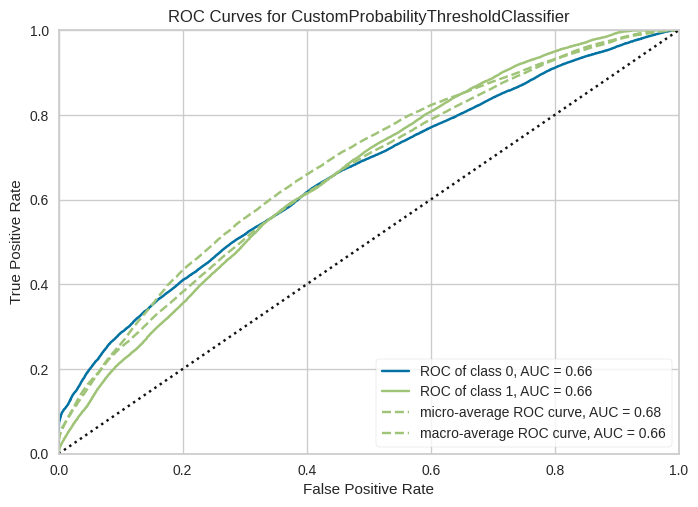

In [189]:
plot_model(regression_model, plot = 'auc')

see the higher threshold catches smaller portion (recall ~ 5%) but with much higher precision 72%.

In [190]:
train_prediction = pycaret.classification.predict_model(data = train_data, estimator = regression_model)
train_prediction = pd.merge(train_prediction, df_player_team_positions[['player_id','player_team_name']], left_on='batting_id', right_on='player_id', how='left')
train_prediction["theo_odds"] = train_prediction["prediction_score"].apply(model.common.odds_calculator)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6306,0.6561,0.8118,0.6347,0.7124,0.2171,0.2303


In [191]:
score_threshold = 0.75
confident_train_prediction = train_prediction[(train_prediction["prediction_score"] >= score_threshold) & (train_prediction["prediction_label"] == 1)].sort_values(by = "prediction_score", ascending = False).drop_duplicates("batting_name")
confident_train_prediction[['game_date', "batting_name", "batting_hit_recorded",	"prediction_score", "player_team_name", "theo_odds"]]

,game_date,batting_name,batting_hit_recorded,prediction_score,player_team_name,theo_odds
967737,2022-08-13,Chadwick Tromp,1,0.9973,Atlanta Braves,-36937
349038,2015-06-06,Dee Strange-Gordon,1,0.8825,Washington Nationals,-751
742092,2019-06-19,Jorge Bonifacio,0,0.8702,Kansas City Royals,-670
239228,2014-05-13,Jose Altuve,1,0.8674,Houston Astros,-654
810984,2020-09-01,Jose Iglesias,0,0.8656,Colorado Rockies,-644
...,...,...,...,...,...,...
638731,2018-05-28,Scooter Gennett,1,0.7519,San Francisco Giants,-303
937728,2022-06-06,Tyler Stephenson,1,0.7510,Cincinnati Reds,-302
13272,2012-04-23,Alejandro De Aza,1,0.7505,Chicago White Sox,-301
399544,2015-09-19,Kole Calhoun,1,0.7502,Texas Rangers,-300


In [192]:
confident_train_prediction.batting_hit_recorded.sum() / len(confident_train_prediction)

0.8136645962732919

**test prediction**

In [193]:
train_data.columns

Index(['pitching_gamesPlayed', 'pitching_runs_per_game',
       'pitching_strikeOuts_per_game', 'pitching_hits_per_game', 'pitching_id',
       'batting_name', 'batting_gamesPlayed', 'batting_runs_per_game',
       'batting_strikeOuts_per_game', 'batting_hits_per_game', 'batting_rbi',
       'batting_id', 'pitching_name', 'batting_hit_recorded',
       'pitching_cur_season_runs_per_game',
       'pitching_cur_season_strikeOuts_per_game',
       'pitching_cur_season_hits_per_game', 'batting_cur_season_runs_per_game',
       'batting_cur_season_strikeOuts_per_game',
       'batting_cur_season_hits_per_game', 'temp', 'game_venue', 'game_date',
       'game_year'],
      dtype='object')

In [194]:
test_data.columns

Index(['pitching_gamesPlayed', 'pitching_runs_per_game',
       'pitching_strikeOuts_per_game', 'pitching_hits_per_game', 'pitching_id',
       'batting_name', 'batting_gamesPlayed', 'batting_runs_per_game',
       'batting_strikeOuts_per_game', 'batting_hits_per_game', 'batting_rbi',
       'batting_id', 'pitching_name', 'batting_hit_recorded',
       'pitching_cur_season_runs_per_game',
       'pitching_cur_season_strikeOuts_per_game',
       'pitching_cur_season_hits_per_game', 'batting_cur_season_runs_per_game',
       'batting_cur_season_strikeOuts_per_game',
       'batting_cur_season_hits_per_game', 'temp', 'game_venue', 'game_date',
       'game_year'],
      dtype='object')

In [195]:
test_prediction = pycaret.classification.predict_model(data = test_data, estimator = regression_model)
test_prediction = pd.merge(test_prediction, df_player_team_positions[['player_id','player_team_name']], left_on='batting_id', right_on='player_id', how='left')
test_prediction["theo_odds"] = test_prediction["prediction_score"].apply(model.common.odds_calculator)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5909,0.6158,0.7647,0.6222,0.6861,0.1165,0.1217


In [196]:
score_threshold = 0.75
confident_test_prediction = test_prediction[(test_prediction["prediction_score"] >= score_threshold) & (test_prediction["prediction_label"] == 1)].sort_values(by = "prediction_score", ascending = False).drop_duplicates("batting_name")
confident_test_prediction[['game_date', "batting_name", "batting_hit_recorded",	"prediction_score", "player_team_name", "theo_odds"]]

,game_date,batting_name,batting_hit_recorded,prediction_score,player_team_name,theo_odds
3297,2023-04-08,Adam Duvall,1,0.8916,Miami Marlins,-823
12718,2023-04-29,Luis Arraez,1,0.8896,Miami Marlins,-806
6590,2023-04-15,Joey Meneses,1,0.8324,Washington Nationals,-497
24695,2023-05-30,Bo Bichette,1,0.8284,Toronto Blue Jays,-483
16931,2023-05-09,Thairo Estrada,1,0.8190,New York Yankees,-452
17291,2023-05-10,Christopher Morel,1,0.8152,Chicago Cubs,-441
7130,2023-04-16,Bryson Stott,1,0.8133,Philadelphia Phillies,-436
7725,2023-04-17,Nico Hoerner,1,0.8087,Chicago Cubs,-423
1860,2023-04-04,Corey Seager,1,0.7988,Texas Rangers,-397
10264,2023-04-23,Jorge Polanco,1,0.7960,Minnesota Twins,-390


In [197]:
confident_test_prediction.batting_hit_recorded.sum() / len(confident_test_prediction)

0.7931034482758621

**Finalize & Save Model**

In [198]:
# train over the whole dataset without validation split
regressin_model_finalized = pycaret.classification.finalize_model(regressin_model)

In [199]:
pycaret.classification.save_model(regressin_model_finalized, model.common.model_file_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['pitching_gamesPlayed',
                                              'pitching_runs_per_game',
                                              'pitching_strikeOuts_per_game',
                                              'pitching_hits_per_game',
                                              'batting_gamesPlayed',
                                              'batting_runs_per_game',
                                              'batting_strikeOuts_per_game',
                                              'batting_hits_per_game',
                                              'batting_rbi',
                                              'pitching_cur_...
                                                                                     multi_class='auto',
                                                 